# Forecasting flight delays for domestic flights in US 

The ideia behind this project is to develop a model to predict flight delays (in minutes) at arrival for domestic flights in the US. The data used here was download from the Bureau of Transportation Statistics ([BTS](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)). 

The dataset comprises data between November 2017 and October 2018, with almost 7 millions training examples. It has the following features: 

----------------
----------------
**Features:**
* Year: 2017 to 2018.             
* Month: 1 to 12.                   
* Day_of_month: 1 to 31.            
* Day_of_week: 1 (Monday) to 7 (Sunday), 9 (Unknown).                       
* Op_carrier: Code assigned by IATA and commonly used to identify a carrier. May not be unique.         
* Op_carrier_fl_num: Flight number.             
* Origin: Origin airport.                               
* Origin_city_name: City name of the origin airport.                
* Origin_state_nm: State code of the origin airport.                  
* Dest: Destination airport.              
* Dest_city_name: City name of the destination airport.                
* Dest_state_nm: State name of the destination airport.                   
* CRS_dep_time: The schedule departure time (local time: hhmm).           
* Dep_delay_new: Difference in minutes between scheduled and actual departure time. Early departures set to 0.                 
* CRS_arr_time: The schedule arrival time (local time: hhmm).                                                    
* Arr_delay_new: Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                  
* Cancelled: Cancelled flight indicator, 0 (No), 1 (Yes).                                                       
* Diverted: Diverted flight indicator, 0 (No), 1 (Yes).               
* CRS_elapsed_time: The schedule elapsed time of flight, in minutes.                  
* Distance: Distance between aiportes, in miles.                      
---------------------

## 1. Overview of the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
jun_2017 = pd.read_csv('./CSV_files/2017_06.csv')
jul_2017 = pd.read_csv('./CSV_files/2017_07.csv')
ago_2017 = pd.read_csv('./CSV_files/2017_08.csv')
sep_2017 = pd.read_csv('./CSV_files/2017_09.csv')
oct_2017 = pd.read_csv('./CSV_files/2017_10.csv')
nov_2017 = pd.read_csv('./CSV_files/2017_11.csv')
dec_2017 = pd.read_csv('./CSV_files/2017_12.csv')
jan_2018 = pd.read_csv('./CSV_files/2018_01.csv')
feb_2018 = pd.read_csv('./CSV_files/2018_02.csv')
mar_2018 = pd.read_csv('./CSV_files/2018_03.csv')
apr_2018 = pd.read_csv('./CSV_files/2018_04.csv')
may_2018 = pd.read_csv('./CSV_files/2018_05.csv')
jun_2018 = pd.read_csv('./CSV_files/2018_06.csv')
jul_2018 = pd.read_csv('./CSV_files/2018_07.csv')
aug_2018 = pd.read_csv('./CSV_files/2018_08.csv')
sep_2018 = pd.read_csv('./CSV_files/2018_09.csv')
oct_2018 = pd.read_csv('./CSV_files/2018_10.csv')

In [4]:
nov_2017.sample(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
408646,2017,11,30,4,DL,1537,FAY,"Fayetteville, NC",North Carolina,ATL,"Atlanta, GA",Georgia,600,0.0,734,0.0,0,0,94,331
80466,2017,11,18,6,VX,1903,LAS,"Las Vegas, NV",Nevada,SFO,"San Francisco, CA",California,1000,0.0,1135,0.0,0,0,95,414
196809,2017,11,2,4,OO,4934,PIA,"Peoria, IL",Illinois,ATL,"Atlanta, GA",Georgia,600,0.0,851,0.0,0,0,111,565
334149,2017,11,25,6,AA,2113,PHL,"Philadelphia, PA",Pennsylvania,RSW,"Fort Myers, FL",Florida,1855,0.0,2152,1.0,0,0,177,993
316696,2017,11,9,4,AA,2314,RIC,"Richmond, VA",Virginia,DFW,"Dallas/Fort Worth, TX",Texas,700,0.0,940,0.0,0,0,220,1158
127864,2017,11,8,3,WN,1941,RSW,"Fort Myers, FL",Florida,MDW,"Chicago, IL",Illinois,1855,0.0,2050,0.0,0,0,175,1105
385452,2017,11,27,1,DL,1724,EWR,"Newark, NJ",New Jersey,SLC,"Salt Lake City, UT",Utah,1758,0.0,2111,0.0,0,0,313,1969
422757,2017,11,21,2,DL,2223,DTW,"Detroit, MI",Michigan,BNA,"Nashville, TN",Tennessee,1015,0.0,1054,0.0,0,0,99,456
159224,2017,11,13,1,WN,247,HOU,"Houston, TX",Texas,OKC,"Oklahoma City, OK",Oklahoma,835,6.0,1005,1.0,0,0,90,419
4397,2017,11,24,5,UA,395,BWI,"Baltimore, MD",Maryland,ORD,"Chicago, IL",Illinois,1158,0.0,1305,0.0,0,0,127,622


In [5]:
monthly_csv_dic = {'06/2017':jun_2017,'07/2017':jul_2017,'08/2017':ago_2017,'09/2017':sep_2017,'10/2017':oct_2017,
                   '11/2017':nov_2017, '12/2017':dec_2017, '01/2018':jan_2018, '02/2018':feb_2018, '03/2018':mar_2018, 
                   '04/2018':apr_2018,'05/2018':may_2018, '06/2018':jun_2018, '07/2018':jul_2018, '08/2018':aug_2018, 
                   '09/2018':sep_2018, '10/2018':oct_2018 }

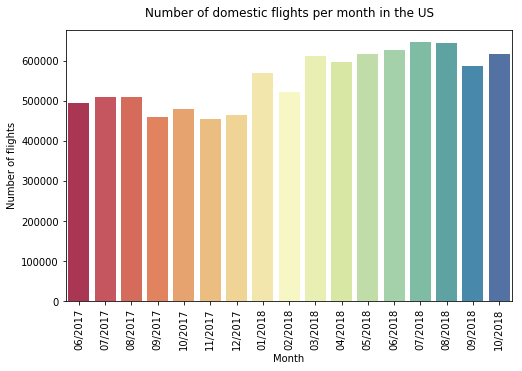

In [6]:
nflights_per_month = [len(df) for df in monthly_csv_dic.values()]
months = list(monthly_csv_dic.keys())

plt.figure(figsize=(8,5))
grid = sns.barplot(x=months, y=nflights_per_month, palette=sns.color_palette("Spectral",17))
grid.set_title('Number of domestic flights per month in the US', y=1.025)
grid.set_xlabel('Month')
grid.set_ylabel('Number of flights')
plt.xticks(rotation=90)
plt.show()

The number of flights per month isn't constant all over the year. Would be that due to seasonality or there were flights that were not included in the data report?
Apparently, the number of flights also increased from 2017 to 2018.

----------
----------

In [7]:
def plot_flights_per_day(df_dict):
    for i in range(5,len(df_dict)):
        plt.figure(figsize=(8,5))
        grid = sns.countplot(x='DAY_OF_MONTH', data=list(df_dict.values())[i], palette=sns.color_palette("Spectral",31), 
                             zorder=2)
        grid.set_title(list(df_dict.keys())[i])
        grid.set_xlabel('Days of month')
        grid.set_ylabel('Number of flights')
        plt.ylim(8000, 24000)
        grid.yaxis.grid(which='both', linestyle='--')
        plt.show()

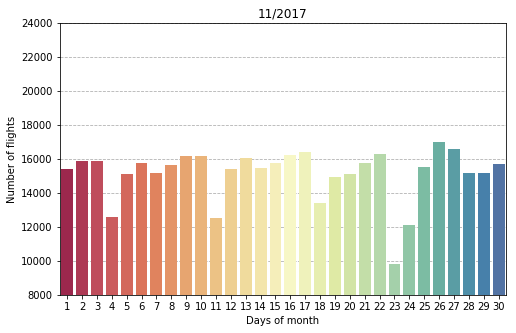

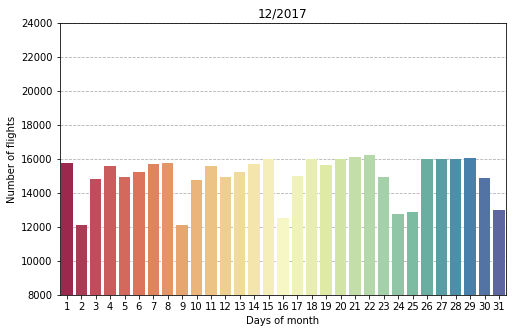

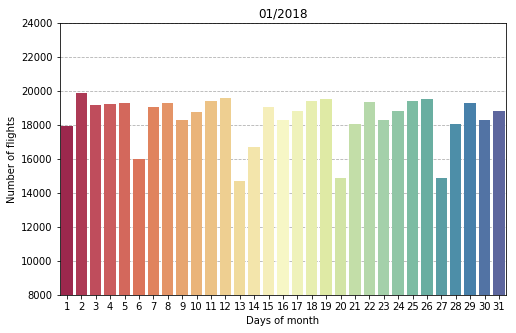

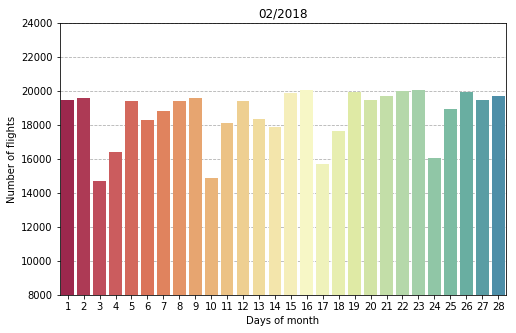

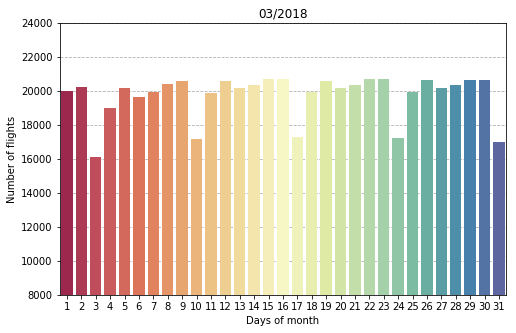

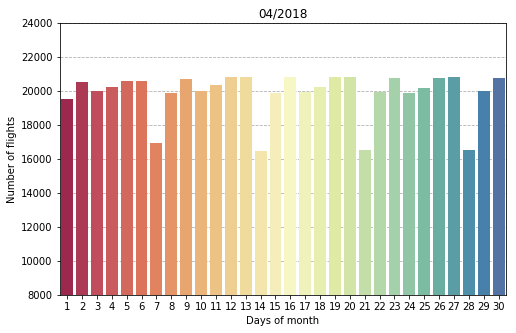

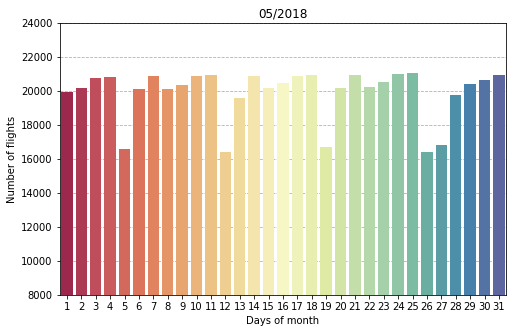

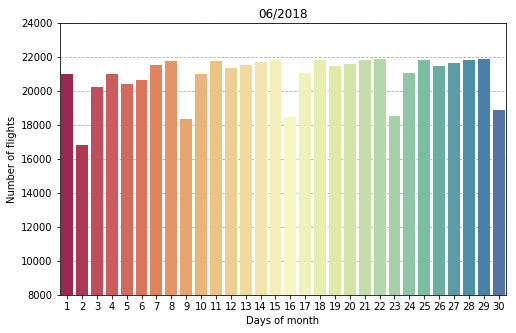

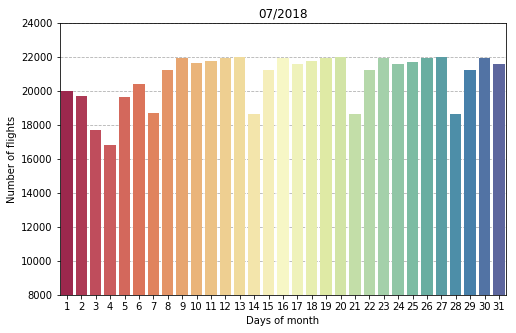

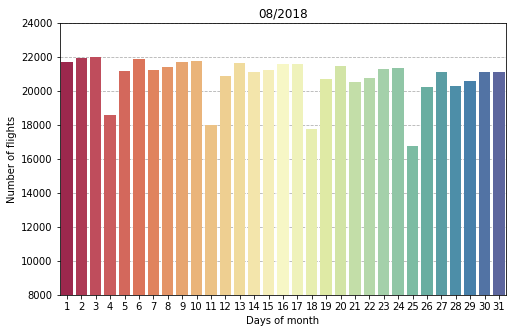

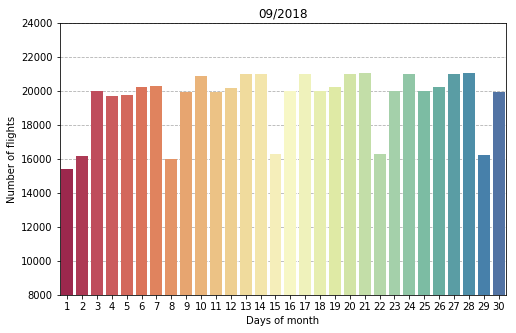

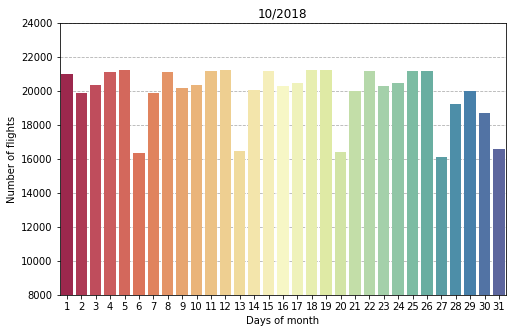

In [8]:
#ploting daily count of flights from November2017 to October2018
plot_flights_per_day(monthly_csv_dic)

-----
-----
There is some kind of periodicity in the flights count, which is probably related to days of week. Interestingly, the number of flights is reduced in approximately 2k every 7 days (it seems to be Saturdays).

-----
-----

In [9]:
# concating the monthly df in one annual df (from Nov2017 to Oct2018)
dataframes = [df for df in monthly_csv_dic.values()]
oneyearflights_raw = pd.concat(dataframes[5:], ignore_index=True)

In [10]:
oneyearflights_raw.sample(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
5546050,2018,8,26,7,MQ,3540,SGF,"Springfield, MO",Missouri,ORD,"Chicago, IL",Illinois,606,0.0,747,0.0,0,0,101.0,438
5031028,2018,7,18,3,F9,1271,MKE,"Milwaukee, WI",Wisconsin,AUS,"Austin, TX",Texas,901,0.0,1153,0.0,0,0,172.0,1032
2207056,2018,3,29,4,WN,6522,BNA,"Nashville, TN",Tennessee,FLL,"Fort Lauderdale, FL",Florida,1400,9.0,1710,3.0,0,0,130.0,793
117815,2017,11,28,2,WN,6852,STL,"St. Louis, MO",Missouri,SAN,"San Diego, CA",California,910,0.0,1120,0.0,0,0,250.0,1557
4260732,2018,6,14,4,UA,1132,DEN,"Denver, CO",Colorado,PHL,"Philadelphia, PA",Pennsylvania,1744,4.0,2323,4.0,0,0,219.0,1558
3990662,2018,6,11,1,OO,5552,ORD,"Chicago, IL",Illinois,GRR,"Grand Rapids, MI",Michigan,1746,0.0,1945,0.0,0,0,59.0,137
6082428,2018,9,7,5,OO,5421,COS,"Colorado Springs, CO",Colorado,DEN,"Denver, CO",Colorado,1157,0.0,1244,0.0,0,0,47.0,73
725152,2017,12,29,5,WN,693,LAS,"Las Vegas, NV",Nevada,RNO,"Reno, NV",Nevada,1330,5.0,1450,4.0,0,0,80.0,345
3248879,2018,5,7,1,UA,1188,MSY,"New Orleans, LA",Louisiana,ORD,"Chicago, IL",Illinois,800,0.0,1025,0.0,0,0,145.0,837
4426233,2018,6,1,5,AS,150,ANC,"Anchorage, AK",Alaska,LAX,"Los Angeles, CA",California,2320,0.0,534,0.0,0,0,314.0,2345


In [11]:
oneyearflights_raw.shape

(6951793, 20)

In [12]:
oneyearflights_raw.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6951793 entries, 0 to 6951792
Data columns (total 20 columns):
YEAR                 6951793 non-null int64
MONTH                6951793 non-null int64
DAY_OF_MONTH         6951793 non-null int64
DAY_OF_WEEK          6951793 non-null int64
OP_CARRIER           6951793 non-null object
OP_CARRIER_FL_NUM    6951793 non-null int64
ORIGIN               6951793 non-null object
ORIGIN_CITY_NAME     6951793 non-null object
ORIGIN_STATE_NM      6951793 non-null object
DEST                 6951793 non-null object
DEST_CITY_NAME       6951793 non-null object
DEST_STATE_NM        6951793 non-null object
CRS_DEP_TIME         6951793 non-null int64
DEP_DELAY_NEW        6840579 non-null float64
CRS_ARR_TIME         6951793 non-null int64
ARR_DELAY_NEW        6821983 non-null float64
CANCELLED            6951793 non-null int64
DIVERTED             6951793 non-null int64
CRS_ELAPSED_TIME     6951783 non-null float64
DISTANCE             6951793 non-null 

In [13]:
oneyearflights_raw.isnull().sum()

YEAR                      0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
OP_CARRIER                0
OP_CARRIER_FL_NUM         0
ORIGIN                    0
ORIGIN_CITY_NAME          0
ORIGIN_STATE_NM           0
DEST                      0
DEST_CITY_NAME            0
DEST_STATE_NM             0
CRS_DEP_TIME              0
DEP_DELAY_NEW        111214
CRS_ARR_TIME              0
ARR_DELAY_NEW        129810
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME         10
DISTANCE                  0
dtype: int64

------------
-------------
There are some missing values in three of the 20 features: DEP_DELAY_NEW, ARR_DELAY_NEW (the target), 'CRS_ELAPSED_TIME. Some of these missing values may be due to flights that were cancelled or diverted. As we are only intereted in flights that haven't been neither cancelled nor diverted, we can drop all rows where 'CANCELLED' or 'DIVERTED' reads 1. 

After that we can also drop both CANCELLED AND DIVERTED features as they don't really give us much information.

-------------
-------------

In [14]:
oneyearflights_raw.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
count,6.951793e+06,6.951793e+06,6.951793e+06,6.951793e+06,6.951793e+06,6.951793e+06,6.840579e+06,6.951793e+06,6.821983e+06,6.951793e+06,6.951793e+06,6.951783e+06,6.951793e+06
mean,2.017868e+03,6.378930e+00,1.576328e+01,3.931192e+00,2.555310e+03,1.330185e+03,1.295664e+01,1.485373e+03,1.309001e+01,1.586929e-02,2.430021e-03,1.420295e+02,8.078154e+02
std,3.386050e-01,3.317581e+00,8.766044e+00,1.988954e+00,1.860811e+03,4.917453e+02,4.329877e+01,5.199706e+02,4.302310e+01,1.249698e-01,4.923531e-02,7.397710e+01,6.025167e+02
min,2.017000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,3.100000e+01
25%,2.018000e+03,4.000000e+00,8.000000e+00,2.000000e+00,9.730000e+02,9.140000e+02,0.000000e+00,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,8.900000e+01,3.660000e+02
50%,2.018000e+03,6.000000e+00,1.600000e+01,4.000000e+00,2.055000e+03,1.321000e+03,0.000000e+00,1.515000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.230000e+02,6.410000e+02
75%,2.018000e+03,9.000000e+00,2.300000e+01,6.000000e+00,4.032000e+03,1.735000e+03,6.000000e+00,1.919000e+03,7.000000e+00,0.000000e+00,0.000000e+00,1.720000e+02,1.042000e+03
max,2.018000e+03,1.200000e+01,3.100000e+01,7.000000e+00,7.439000e+03,2.359000e+03,2.710000e+03,2.400000e+03,2.692000e+03,1.000000e+00,1.000000e+00,7.040000e+02,4.983000e+03


In [15]:
oneyearflights_raw.describe(include=['O'])

,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM
count,6951793,6951793,6951793,6951793,6951793,6951793,6951793
unique,18,355,349,52,356,350,52
top,WN,ATL,"Chicago, IL",California,ATL,"Chicago, IL",California
freq,1347369,383901,406414,789820,383906,406345,789874


---
---
Features to check for dubious values:      
(1) OP_CARRIER_FL_NUM: min value is 1;                  
(2) CRS_ELAPSED_TIME: negative value;         
(3) DISTANCE: min value is 31 miles.

----
----

### 1.1. Copying the ***oneyearflights_raw*** dataframe

In [16]:
flights_df = oneyearflights_raw.copy()

                             
### 1.2. Feature control dataset

In [17]:
# Create a pandas DataFrame to control features' status

FeatCtrl = ['0 - not inspected',                      
            '1 - inspected and ready',                   
            '2 - drop before training',                        
            '3 - created', 
            '4 - created and should be dropped',
            '5 - inspected and consider binning']  

flights_FeatCtrl = pd.DataFrame(np.zeros((1,len(flights_df.columns))), dtype=int, columns = flights_df.columns)
print(flights_FeatCtrl.shape)

(1, 20)


## 2. Cleaning

In [18]:
# flights that were either cancelled or diverted
flights_df.loc[(flights_df.DIVERTED == 1) | (flights_df.CANCELLED == 1)].isnull().sum()

YEAR                      0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
OP_CARRIER                0
OP_CARRIER_FL_NUM         0
ORIGIN                    0
ORIGIN_CITY_NAME          0
ORIGIN_STATE_NM           0
DEST                      0
DEST_CITY_NAME            0
DEST_STATE_NM             0
CRS_DEP_TIME              0
DEP_DELAY_NEW        106489
CRS_ARR_TIME              0
ARR_DELAY_NEW        127211
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME         10
DISTANCE                  0
dtype: int64

In [19]:
#droping flights that were cancelled or diverted
flights_df = flights_df.loc[(flights_df.DIVERTED == 0) & (flights_df.CANCELLED == 0)]

In [20]:
flights_FeatCtrl['CANCELLED'] = 2
flights_FeatCtrl['DIVERTED'] = 2

In [21]:
flights_df.isnull().sum()

YEAR                    0
MONTH                   0
DAY_OF_MONTH            0
DAY_OF_WEEK             0
OP_CARRIER              0
OP_CARRIER_FL_NUM       0
ORIGIN                  0
ORIGIN_CITY_NAME        0
ORIGIN_STATE_NM         0
DEST                    0
DEST_CITY_NAME          0
DEST_STATE_NM           0
CRS_DEP_TIME            0
DEP_DELAY_NEW        4725
CRS_ARR_TIME            0
ARR_DELAY_NEW        2599
CANCELLED               0
DIVERTED                0
CRS_ELAPSED_TIME        0
DISTANCE                0
dtype: int64

In [22]:
# null_data is a subset of flights_df that only have instances with at least one missing value 
# (subset created with the purpose to further check the data having missing values)
null_data = flights_df[flights_df.isnull().any(axis=1)]
null_data.sample(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
3767285,2018,5,3,4,9E,4085,CVG,"Cincinnati, OH",Kentucky,MSP,"Minneapolis, MN",Minnesota,1738,NaN,1840,0.0,0,0,122.0,596
3132667,2018,4,11,3,9E,3446,TYS,"Knoxville, TN",Tennessee,ATL,"Atlanta, GA",Georgia,1158,NaN,1305,0.0,0,0,67.0,152
4473061,2018,7,12,4,9E,5447,BOS,"Boston, MA",Massachusetts,PIT,"Pittsburgh, PA",Pennsylvania,824,NaN,1010,0.0,0,0,106.0,496
5138757,2018,8,27,1,9E,5134,LGA,"New York, NY",New York,TYS,"Knoxville, TN",Tennessee,2021,NaN,2241,0.0,0,0,140.0,648
3771407,2018,5,22,2,9E,5154,ATL,"Atlanta, GA",Georgia,FAY,"Fayetteville, NC",North Carolina,1717,NaN,1834,9.0,0,0,77.0,331
5140917,2018,8,18,6,9E,5205,ORF,"Norfolk, VA",Virginia,LGA,"New York, NY",New York,1150,NaN,1317,0.0,0,0,87.0,296
4465306,2018,7,7,6,9E,3438,BHM,"Birmingham, AL",Alabama,ATL,"Atlanta, GA",Georgia,1318,NaN,1524,16.0,0,0,66.0,134
2526289,2018,3,8,4,9E,3358,SGF,"Springfield, MO",Missouri,ATL,"Atlanta, GA",Georgia,600,NaN,850,10.0,0,0,110.0,563
3771436,2018,5,25,5,9E,5154,FAY,"Fayetteville, NC",North Carolina,ATL,"Atlanta, GA",Georgia,1859,7.0,2029,NaN,0,0,90.0,331
3135430,2018,4,17,2,9E,5156,MSP,"Minneapolis, MN",Minnesota,CLT,"Charlotte, NC",North Carolina,2015,NaN,2356,0.0,0,0,161.0,930


In [23]:
null_data.describe(include=['O'])

,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM
count,7187,7187,7187,7187,7187,7187,7187
unique,1,119,117,35,123,121,36
top,9E,ATL,"New York, NY",New York,ATL,"New York, NY",New York
freq,7187,924,1405,1681,774,1460,1771


--------
--------
All instances that have at least one missing value are from flights operated by the airline 9E.

--------
--------

In [24]:
null_data.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
count,7187.0,7187.000000,7187.000000,7187.000000,7187.000000,7187.000000,2462.000000,7187.000000,4588.000000,7187.0,7187.0,7187.000000,7187.000000
mean,2018.0,4.732990,15.754418,3.845972,4173.358842,1304.526089,2.763201,1485.121052,3.323452,0.0,0.0,109.399750,476.010992
std,0.0,2.184778,8.697994,1.967892,803.255658,451.955552,5.872371,453.931326,9.480856,0.0,0.0,36.179218,269.711599
min,2018.0,1.000000,1.000000,1.000000,3280.000000,525.000000,0.000000,10.000000,0.000000,0.0,0.0,40.000000,83.000000
25%,2018.0,3.000000,8.000000,2.000000,3430.000000,933.000000,0.000000,1118.000000,0.000000,0.0,0.0,83.000000,258.000000
50%,2018.0,5.000000,16.000000,4.000000,3931.000000,1300.000000,0.000000,1449.000000,0.000000,0.0,0.0,103.000000,425.000000
75%,2018.0,7.000000,23.000000,5.000000,5122.000000,1655.000000,2.000000,1843.500000,1.000000,0.0,0.0,131.000000,641.000000
max,2018.0,8.000000,31.000000,7.000000,5479.000000,2336.000000,46.000000,2356.000000,148.000000,0.0,0.0,266.000000,1391.000000


In [25]:
# quicly checking how many flights there were per airline, especially 9E
flights_df.OP_CARRIER.value_counts()

WN    1326838
DL     937768
AA     893851
OO     754198
UA     609657
B6     296592
YX     255062
MQ     235796
AS     231853
OH     221441
EV     210403
9E     199277
YV     172790
NK     170634
F9     116446
HA      82531
G4      80014
VX      29431
Name: OP_CARRIER, dtype: int64

------------
------------
Just by dropping the flights that were either cancelled or diverted, the number of missing values of DEP_DELAY_NEW and ARR_DELAY_NEW decreased significantly, but we still have some missing values to deal with. All the remaning missing values are from flights operated by the airline 9E (Endeavor Air), which is interesting. We could input these missing values with the mean or median values, but, given the size of the dataset, I guess we can drop these values without losing too much information. Furthermore, I don't see the point of filling in the missing values of the dependent variable (ARR_DELAY_NEW).

------------
------------

In [26]:
#drop all remaining missing values
flights_df = flights_df.dropna()

In [27]:
flights_df.isnull().sum()

YEAR                 0
MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
ORIGIN_CITY_NAME     0
ORIGIN_STATE_NM      0
DEST                 0
DEST_CITY_NAME       0
DEST_STATE_NM        0
CRS_DEP_TIME         0
DEP_DELAY_NEW        0
CRS_ARR_TIME         0
ARR_DELAY_NEW        0
CANCELLED            0
DIVERTED             0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64

----------
----------
Now that there isn't any remaining missing value in the dependent variable, we can check the frequency that flights are delayed.

----------
----------

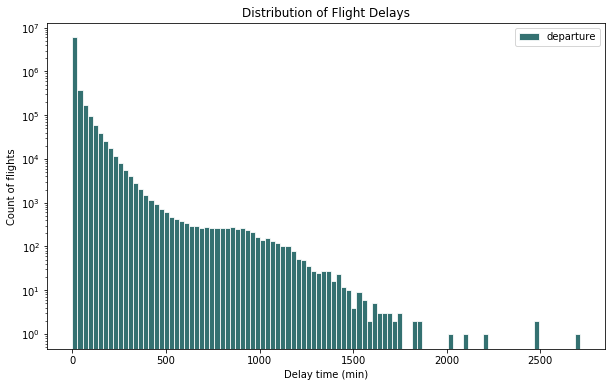

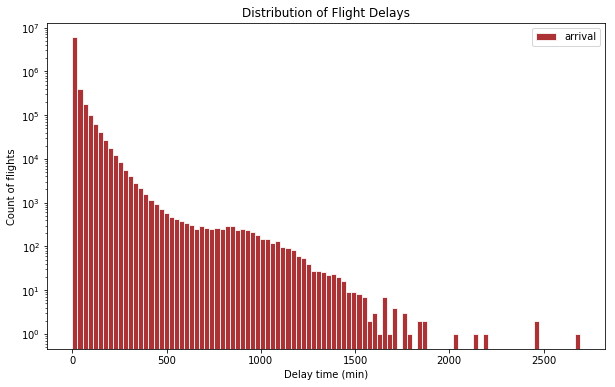

In [28]:
plt.figure(figsize=(10,6))
grid = sns.distplot(flights_df['DEP_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['dark teal'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='departure')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time (min)')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
grid = sns.distplot(flights_df['ARR_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['blood red'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='arrival')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time (min)')
plt.legend()
plt.show()

In [29]:
delay_bins = pd.cut(flights_df.ARR_DELAY_NEW, [-1, 0, 5, 10, 20, 30, 60, 120, 240, 3000]
                   ).value_counts().sort_index()
delay_bins

(-1, 0]        4450532
(0, 5]          525212
(5, 10]         362065
(10, 20]        442546
(20, 30]        254848
(30, 60]        367543
(60, 120]       255299
(120, 240]      124311
(240, 3000]      35039
Name: ARR_DELAY_NEW, dtype: int64

In [30]:
flights_df.shape[0]

6817395

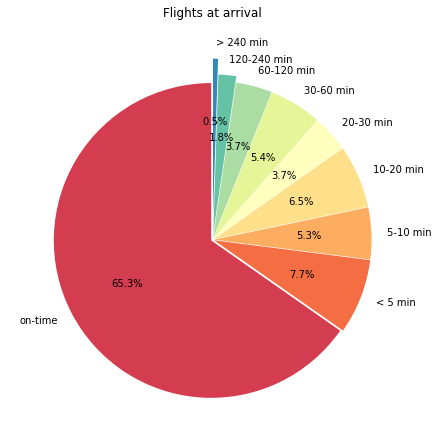

In [31]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0.1, 1, 10)]
labels = ['on-time', '< 5 min', '5-10 min', '10-20 min', '20-30 min', '30-60 min', '60-120 min', '120-240 min', '> 240 min']
explodeTuple = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.15)

grid = delay_bins.plot.pie(y=delay_bins.index, startangle=90, labels=labels,
                           autopct='%1.1f%%', colors=colors, explode=explodeTuple)
grid.axis('equal')
grid.yaxis.set_label_text('')
grid.set_title('Flights at arrival', y=1.05)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.tight_layout()
plt.show()

Most of flights arrived on time. From those that arrived late, 56.2% were delayed by 20 min or less and 0.5% were delayed by more than 4h. Could them be considered outliers?

------
------

* ##### Converting CRS_DEP_TIME and CRS_ARR_TIME to time

In [32]:
# Converting CRS_DEP_TIME and CRS_ARR_TIME to time

def time_in_hour(df):
    df[['CRS_DEP_TIME', 'CRS_ARR_TIME']] = df[['CRS_DEP_TIME', 'CRS_ARR_TIME']].astype(str)
    df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].str.replace('2400', '0000', regex=False)
    df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].str.replace('2400', '0000', regex=False)
    df['CRS_DEP_TIME'] = df.CRS_DEP_TIME.str.zfill(4)
    df['CRS_ARR_TIME'] = df.CRS_ARR_TIME.str.zfill(4)   
    
    df['SCHEDULED_DEP'] = pd.to_datetime(df.CRS_DEP_TIME, format='%H%M').dt.time
    df['SCHEDULED_DEP'] = pd.to_timedelta(df['SCHEDULED_DEP'].astype(str))
    df['SCHEDULED_ARR'] = pd.to_datetime(df.CRS_ARR_TIME, format='%H%M').dt.time
    df['SCHEDULED_ARR'] = pd.to_timedelta(df['SCHEDULED_ARR'].astype(str))

In [33]:
time_in_hour(flights_df)

In [34]:
flights_df.sample(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR
2527745,2018,3,14,3,9E,3401,CVG,"Cincinnati, OH",Kentucky,DFW,"Dallas/Fort Worth, TX",Texas,1622,0.0,1758,0.0,0,0,156.0,812,16:22:00,17:58:00
495421,2017,12,30,6,OO,5237,CHS,"Charleston, SC",South Carolina,ORD,"Chicago, IL",Illinois,1420,25.0,1555,26.0,0,0,155.0,760,14:20:00,15:55:00
548807,2017,12,12,2,AA,1747,CLT,"Charlotte, NC",North Carolina,PIT,"Pittsburgh, PA",Pennsylvania,2009,0.0,2136,0.0,0,0,87.0,366,20:09:00,21:36:00
191617,2017,11,27,1,WN,6856,ONT,"Ontario, CA",California,OAK,"Oakland, CA",California,1450,3.0,1605,5.0,0,0,75.0,362,14:50:00,16:05:00
5439386,2018,8,13,1,DL,2951,MSY,"New Orleans, LA",Louisiana,JFK,"New York, NY",New York,0700,0.0,1050,22.0,0,0,170.0,1182,07:00:00,10:50:00
4916754,2018,7,9,1,WN,1470,DAL,"Dallas, TX",Texas,ATL,"Atlanta, GA",Georgia,2150,0.0,0050,0.0,0,0,120.0,721,21:50:00,00:50:00
1612364,2018,2,18,7,AA,1803,TPA,"Tampa, FL",Florida,CLT,"Charlotte, NC",North Carolina,0825,0.0,1015,0.0,0,0,110.0,507,08:25:00,10:15:00
6140840,2018,9,13,4,WN,1282,LGA,"New York, NY",New York,MDW,"Chicago, IL",Illinois,1605,59.0,1740,33.0,0,0,155.0,725,16:05:00,17:40:00
5151421,2018,8,25,6,DL,2597,CLT,"Charlotte, NC",North Carolina,ATL,"Atlanta, GA",Georgia,1448,0.0,1613,0.0,0,0,85.0,226,14:48:00,16:13:00
92349,2017,11,9,4,WN,4351,LAS,"Las Vegas, NV",Nevada,SFO,"San Francisco, CA",California,1240,42.0,1415,46.0,0,0,95.0,414,12:40:00,14:15:00


In [35]:
# features control
flights_FeatCtrl['CRS_DEP_TIME'] = 2
flights_FeatCtrl['CRS_ARR_TIME'] = 2
flights_FeatCtrl['SCHEDULED_DEP'] = 3
flights_FeatCtrl['SCHEDULED_ARR'] = 3

----------
----------
* ##### CRS_ELAPSED_TIME negative values

In [36]:
#The shortest commercial flight in US lasts 16 min
flights_df[flights_df.CRS_ELAPSED_TIME <= 15]

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR
3943001,2018,6,2,6,OO,5132,SLN,"Salina, KS",Kansas,HYS,"Hays, KS",Kansas,1710,0.0,1715,16.0,0,0,5.0,88,17:10:00,17:15:00
4621219,2018,7,10,2,YV,5903,MTJ,"Montrose/Delta, CO",Colorado,DFW,"Dallas/Fort Worth, TX",Texas,1227,13.0,1328,194.0,0,0,1.0,722,12:27:00,13:28:00
4977069,2018,7,4,3,YX,4493,MSP,"Minneapolis, MN",Minnesota,LGA,"New York, NY",New York,0709,43.0,0810,216.0,0,0,1.0,1020,07:09:00,08:10:00
5245848,2018,8,19,7,OH,5123,CLT,"Charlotte, NC",North Carolina,PGV,"Greenville, NC",North Carolina,2225,24.0,2226,89.0,0,0,1.0,203,22:25:00,22:26:00
6577867,2018,10,9,2,YX,3534,ORD,"Chicago, IL",Illinois,TVC,"Traverse City, MI",Michigan,2120,524.0,2336,508.0,0,0,-99.0,224,21:20:00,23:36:00


----
----
It seems that there are a few wrong values for CRS_ELAPSED_TIME. CRS_DEP_TIME and/or CRS_ARR_TIME also have values that do not make sense. Some even don't match with the details of the same flights on other dates. I'm dropping these outliers.

----
----

In [37]:
# keeping only data with CRS_ELAPSED_TIME values higher than 15 min
flights_df = flights_df[flights_df.CRS_ELAPSED_TIME >= 15]

In [ ]:
'''xx = ((flights_df['SCHEDULED_ARR'].loc[6577867]) - (flights_df['SCHEDULED_DEP'].loc[6577867])).total_seconds()


h = xx//3600
m = (xx%3600) // 60
sec =(xx%3600)%60 #just for reference
print ("%d:%d" %(h,m))
'''

-----
-----
* #### DISTANCE minimum value

In [38]:
flights_df[flights_df.DISTANCE == 31].describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.0,712.0,712.000000,712.0,712,712
mean,2017.838483,6.536517,15.748596,4.000000,64.497191,4.657303,5.405899,0.0,0.0,22.495787,31.0,0 days 13:00:10.786516,0 days 13:22:40.533707
std,0.368266,3.406177,8.772640,1.997185,0.500344,16.242812,16.921914,0.0,0.0,1.329101,0.0,0 days 02:11:56.709771,0 days 02:12:02.758135
min,2017.000000,1.000000,1.000000,1.000000,64.000000,0.000000,0.000000,0.0,0.0,20.000000,31.0,0 days 10:30:00,0 days 10:51:00
25%,2018.000000,4.000000,8.000000,2.000000,64.000000,0.000000,0.000000,0.0,0.0,21.000000,31.0,0 days 10:55:00,0 days 11:17:00
50%,2018.000000,7.000000,16.000000,4.000000,64.000000,0.000000,0.000000,0.0,0.0,22.000000,31.0,0 days 14:57:00,0 days 15:19:00
75%,2018.000000,9.000000,23.000000,6.000000,65.000000,0.000000,0.000000,0.0,0.0,23.000000,31.0,0 days 15:14:00,0 days 15:37:00
max,2018.000000,12.000000,31.000000,7.000000,65.000000,150.000000,153.000000,0.0,0.0,26.000000,31.0,0 days 15:29:00,0 days 15:50:00


-----
-----
Apparently there are flights between airports in Alaska that are 31 miles away. So it is a correct value.

---------
---------
## 3. Spliting training-test set

Before further inspecting the data closely, we need to split it into training and test set.
The *flights_df* dataset is not homogeneous. Almost 66% of the data is of flights that arrived on time. From the 34.7% of flights that were delayed, almost 67% were 30 min or less late. Since the goal of this project is to predict flight delay in minutes (regression problem) and not whether it will delay or not (classification problem), we need to ensure that both test and training sets are similar and homogeneous regarding delays-time. Therefore we can split the dataset using the Scikit-Learn's *StratifiedShuffleSplit* class.

The dataset is expressed as a fraction of month, day and airline, so in order to make training and test set more homogeneous, we also need to suffle the data (StratifiedShuffleSplit will do it automatically). It will also enhance the robustness of the cross validation as all cross-validation folds later will be similar.

Let us divide the *ARR_DELAY_NEW* into bins based on delay-time like we did previously:

In [39]:
delay_bins = pd.cut(flights_df.ARR_DELAY_NEW, [-1, 0, 15, 30, 60, 120, 3000]).value_counts().sort_index()
delay_bins / len(flights_df) * 100

(-1, 0]        65.282051
(0, 15]        16.763982
(15, 30]        6.480545
(30, 60]        5.391257
(60, 120]       3.744806
(120, 3000]     2.337361
Name: ARR_DELAY_NEW, dtype: float64

In [40]:
#binning delays by time

def delay_binning(df):
    df['BIN_DEP_DELAY'] = pd.cut(df['DEP_DELAY_NEW'], [-1, 0, 15, 30, 60, 120, 3000], 
                                 labels = ['on-time', '< 15 min', '15-30 min', '30-60 min','60-120 min', '> 120 min'])
    df['BIN_ARR_DELAY'] = pd.cut(df['ARR_DELAY_NEW'], [-1, 0, 15, 30, 60, 120, 3000], 
                                 labels = ['on-time', '< 15 min', '15-30 min', '30-60 min','60-120 min', '> 120 min'])
    
    flights_FeatCtrl['BIN_DEP_DELAY'] = 3
    flights_FeatCtrl['BIN_ARR_DELAY'] = 3
    return df.sample(5)


In [41]:
delay_binning(flights_df)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR,BIN_DEP_DELAY,BIN_ARR_DELAY
3704971,2018,5,3,4,DL,2633,CHS,"Charleston, SC",South Carolina,JFK,"New York, NY",New York,1105,0.0,1300,0.0,0,0,115.0,636,11:05:00,13:00:00,on-time,on-time
3379782,2018,5,10,4,OO,2978,SLC,"Salt Lake City, UT",Utah,ORD,"Chicago, IL",Illinois,0952,0.0,1410,0.0,0,0,198.0,1250,09:52:00,14:10:00,on-time,on-time
6258315,2018,9,6,4,AA,1858,CLT,"Charlotte, NC",North Carolina,ALB,"Albany, NY",New York,2030,5.0,2224,0.0,0,0,114.0,646,20:30:00,22:24:00,< 15 min,on-time
1794641,2018,2,7,3,9E,3673,TLH,"Tallahassee, FL",Florida,ATL,"Atlanta, GA",Georgia,1800,9.0,1912,14.0,0,0,72.0,223,18:00:00,19:12:00,< 15 min,< 15 min
2513556,2018,3,9,5,DL,2768,HNL,"Honolulu, HI",Hawaii,SLC,"Salt Lake City, UT",Utah,2055,0.0,0559,0.0,0,0,364.0,2994,20:55:00,05:59:00,on-time,on-time


In [42]:
# Spliting data into training and test sets
def train_test_split(df):
    df.reset_index(drop=True, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=87)
    for train_index, test_index in split.split(df, df['BIN_ARR_DELAY']):
        train = df.loc[train_index]
        test = df.loc[test_index]
        
    print('Training shape:', train.shape)
    print('Test set shape:', test.shape)
    return (train, test)

In [43]:
flights_train, flights_test = train_test_split(flights_df)

Training shape: (5113042, 24)
Test set shape: (1704348, 24)


In [44]:
#cheking whether stratification worked when spliting into training-test sets
flights_df_bin = flights_df['BIN_ARR_DELAY'].value_counts() / len(flights_df)*100
flights_train_bin = flights_train['BIN_ARR_DELAY'].value_counts() / len(flights_train)*100
flights_test_bin = flights_test['BIN_ARR_DELAY'].value_counts() / len(flights_test)*100

bins_percentage = pd.concat([flights_df_bin, flights_train_bin, flights_test_bin], axis=1, 
                            keys=['original_df','training_set', 'test_set'], join='outer', sort=True)
bins_percentage

,original_df,training_set,test_set
on-time,65.282051,65.282057,65.282032
< 15 min,16.763982,16.763973,16.764006
15-30 min,6.480545,6.480545,6.480543
30-60 min,5.391257,5.391252,5.391270
60-120 min,3.744806,3.744816,3.744775
> 120 min,2.337361,2.337356,2.337375


In [ ]:
'''# binning airports (ORIGIN and DEST) by their flight capacity

def airports_capacity_bins(df):
    airports_flights_per_month = (flights_df['ORIGIN'].value_counts() + flights_df['DEST'].value_counts()) / months_period
    airport_cat = pd.cut(airports_flights_per_month, [0, 250, 500, 1000, 5000, 10000, 20000, 80000], labels = [0,1,2,3,4,5,6])
    df['AIRP_ORIGIN'] = df['ORIGIN'].map(airport_cat).cat.codes
    df['AIRP_DEST'] = df["DEST"].map(airport_cat).cat.codes
    
    return df.sample(5)

flights_FeatCtrl['AIRP_ORIGIN'] = 3
flights_FeatCtrl['AIRP_DEST'] = 3

#creating a dictionary for future reference of airports bins/categories
airport_cat_dict = {0 : '(0, 250]', 1 : '(250, 500]', 2 : '(500, 1000]', 3 : '(1000, 5000]', 4 : '(500, 10000]',
                    5 : '(10000, 20000]', 6 : '(20000, 80000]'}'''

-------------------
-------------------
## 4. Exploratory data analysis

Now that we had our dataset split, we can explore the data a little bit more in depth. To make manipulation easy and fast, let's sample a smaller exploratory set first.

In [45]:
# sampling an exploratory set of 500k training examples
train_explor = flights_train.sample(500000, random_state=87)

In [46]:
train_explor_bin = train_explor['BIN_ARR_DELAY'].value_counts() / len(train_explor)*100

pd.concat([flights_train_bin, train_explor_bin], axis=1, keys=['training_set', 'exploring_set'], join='outer', sort=True)

,training_set,exploring_set
on-time,65.282057,65.2122
< 15 min,16.763973,16.7422
15-30 min,6.480545,6.4996
30-60 min,5.391252,5.4044
60-120 min,3.744816,3.7772
> 120 min,2.337356,2.3644


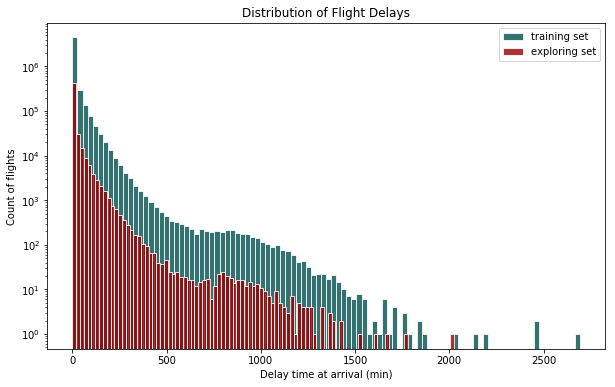

In [47]:
plt.figure(figsize=(10,6))
grid = sns.distplot(flights_train['ARR_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['dark teal'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='training set')
grid = sns.distplot(train_explor['ARR_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['blood red'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='exploring set')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time at arrival (min)')
plt.legend()
plt.show()

-------
-------
It seems that the exploratory set is similar enough to the training set.

Flights there were delayed by more than 4h count for approximately 0.5% of all domestic flights in the US. Such delays are not that recurrent and and may be due to "extraordinary circumstances". I would say they are often beyond the airlines control and are hard to predict. Let's make sure these outliers are no "hidding" any information and if they're not, they might be droped. 

--------
--------

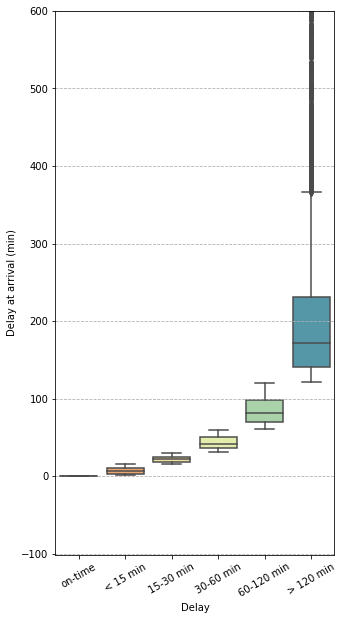

In [48]:
plt.figure(figsize=(5,10))
grid = sns.boxplot(x='BIN_ARR_DELAY', y='ARR_DELAY_NEW', data=train_explor, palette=sns.color_palette("Spectral",6), zorder=2)
grid.yaxis.grid( which='both', linestyle='--')
grid.set_xlabel('Delay')
grid.set_ylabel('Delay at arrival (min)')
plt.xticks(rotation=30)
plt.ylim(None,600)
plt.show()

-----
-----
* ### Comparing flight delays by month

In [49]:
# Calculating the frequency of delays per month. But, the number of flights per month is different, so we can not just count 
# the number of delays per month, but we need to use the percentage of delays per month to make data comparable between months 
# instead, otherwise it could be misleading.

delays_count_month = train_explor[['MONTH', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['MONTH', 'BIN_ARR_DELAY']).agg('count')
delay_per_month = delays_count_month.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [88]:
# probability of delays by min
delays_df = train_explor[train_explor.ARR_DELAY_NEW > 0]

only_delays_count_month = delays_df[['MONTH', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['MONTH', 'BIN_ARR_DELAY']).agg('count')
only_delay_per_month = only_delays_count_month.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

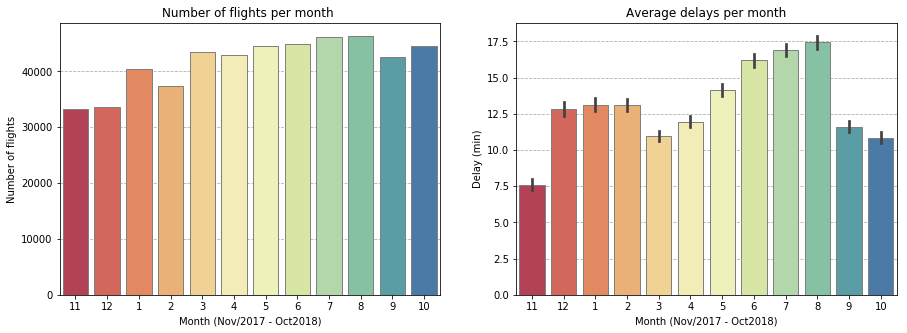

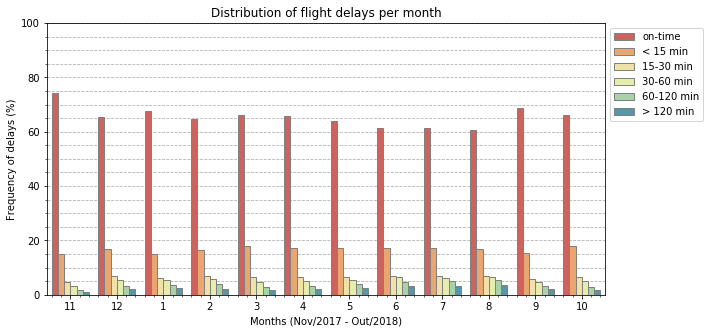

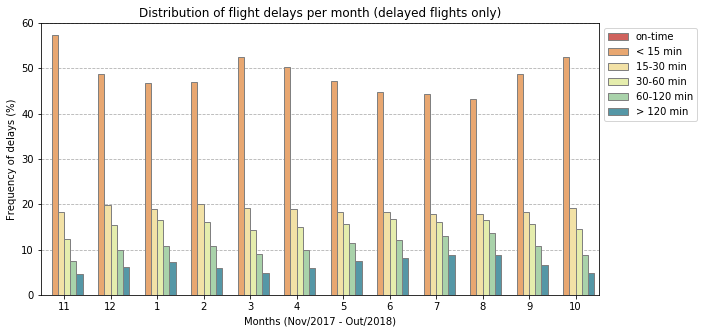

In [92]:
#----- total number of flights per month -----
plt.figure(figsize=(15,5))
plt.subplot(121)
grid = sns.countplot(x='MONTH', data=train_explor, palette=sns.color_palette("Spectral",12), 
                     edgecolor = 'grey', order=[11,12,1,2,3,4,5,6,7,8,9,10], zorder=2)
grid.set_title('Number of flights per month ')
grid.set_ylabel('Number of flights')
grid.set_xlabel('Month (Nov/2017 - Oct2018)')
grid.yaxis.grid( which='both', linestyle='--')


#----- average delays at arrival by month -----
plt.subplot(122)
grid = sns.barplot(x='MONTH', y='ARR_DELAY_NEW', data=train_explor,
                   palette=sns.color_palette("Spectral", 12), edgecolor = 'grey', order=[11,12,1,2,3,4,5,6,7,8,9,10], zorder=2)
grid.set_title('Average delays by month')
grid.set_ylabel('Delay (min)')
grid.set_xlabel('Month (Nov/2017 - Oct2018)')
grid.yaxis.grid(which='both', linestyle='--')
plt.show()


#----- Distribution of delays frequency by month (binned) -----
plt.figure(figsize=(10,5))
grid = sns.barplot(x='MONTH', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_month.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', order=[11,12,1,2,3,4,5,6,7,8,9,10], 
                   zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of flight delays by month')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Months (Nov/2017 - Out/2018)')
grid.yaxis.grid( which='both', linestyle='--')
plt.ylim(0, 100)
grid.minorticks_on()
plt.show()


#----- Distribution of delays frequency by month (delayed flights only, binned) -----
plt.figure(figsize=(10,5))
grid = sns.barplot(x='MONTH', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=only_delay_per_month.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', order=[11,12,1,2,3,4,5,6,7,8,9,10], 
                   zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of flight delays frequency by month (delayed flights only)')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Months (Nov/2017 - Out/2018)')
grid.yaxis.grid( which='both', linestyle='--')
plt.ylim(0, 60)
plt.show()

The number of flights varied from month to month during the period from November 2017 to October 2018 and reached its maximum during the summer season. On an annual average, approximately 65% of flights arrived on-time and almost 15% delayed up to 15 min.
But when we look at months separately, the statistics show that the warmer months June, July and August were below the annual average for punctuality. During the warmer months around 60% of flights arrived on time and delays over 15 min on average could be expected, with a higher probability of even longer delays. On the other hand, almost 74% of flights arrived on-time on November and less then 2% of flights delayed more than 60 min.

We may consider binning months into seasons e test its effect on model performance.

-----
-----

In [135]:
# binning month into seasons
for df in [flights_train, train_explor, flights_test]:
    df['BIN_MONTH'] = np.where((df.MONTH == 12) | (df.MONTH == 1) | (df.MONTH == 2), 
                                      'Winter',
                                      np.where((df.MONTH == 3) | (df.MONTH == 4) | (df.MONTH == 5),
                                      'Spring',
                                      np.where((df.MONTH == 6) | (df.MONTH == 7) | (df.MONTH == 8),
                                      'Summer', 'Autumn')))

# updating feature control df
flights_FeatCtrl['BIN_MONTH'] = 3

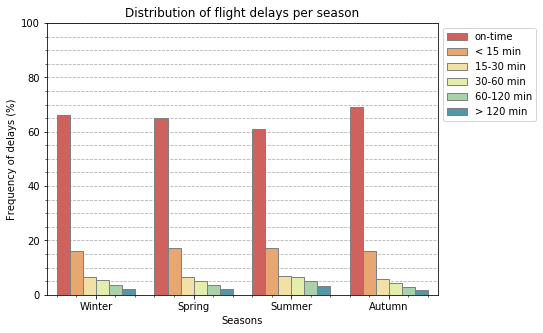

In [104]:
delays_count_season = train_explor[['BIN_MONTH', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['BIN_MONTH', 
                                                                                             'BIN_ARR_DELAY']).agg('count')
delay_per_season = delays_count_season.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

plt.figure(figsize=(7,5))
grid = sns.barplot(x='BIN_MONTH', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_season.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', zorder=2,
                   order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of flight delays by season')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Seasons')
grid.yaxis.grid( which='both', linestyle='--')
plt.ylim(0, 100)
grid.minorticks_on()
plt.show()

-----
-----
* ### Comparing flight delays by weekday

In [105]:
# Calulating the percentage of delays by weekday to make data comparable between weekdays
delays_count_week = train_explor[['DAY_OF_WEEK', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['DAY_OF_WEEK', 
                                                                                             'BIN_ARR_DELAY']).agg('count')
delay_per_week = delays_count_week.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

#only delayed flights
only_delays_count_week = delays_df[['DAY_OF_WEEK', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['DAY_OF_WEEK', 
                                                                                             'BIN_ARR_DELAY']).agg('count')
only_delay_per_week = only_delays_count_week.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

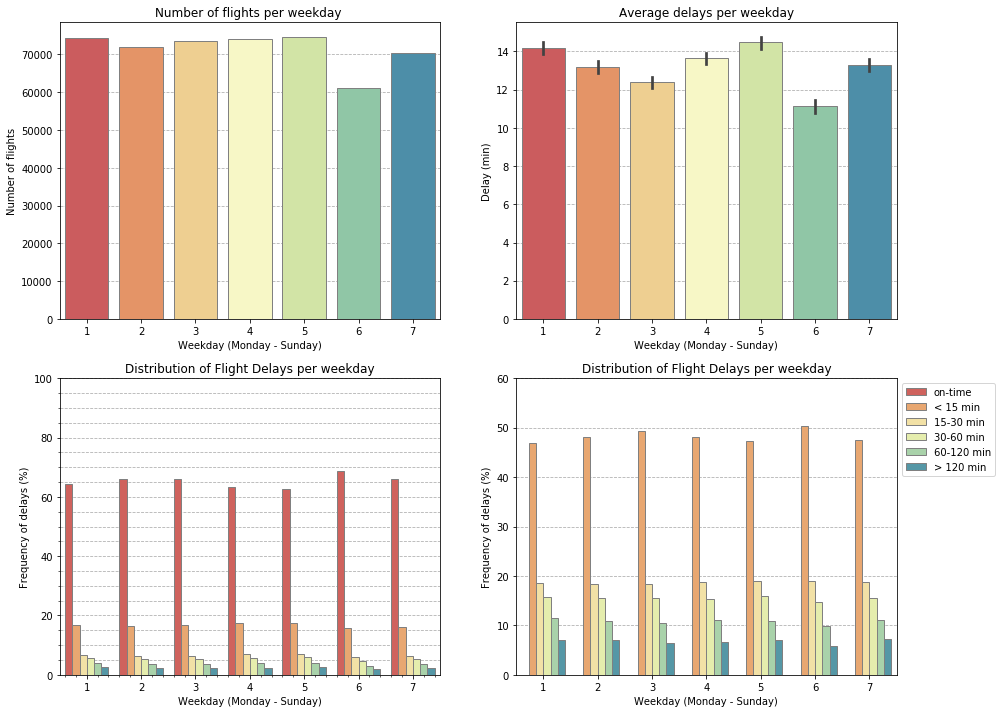

In [109]:
#----- Total number of flights by weekday -----
plt.figure(figsize=(15,12))
plt.subplot(221)
grid = sns.countplot(x='DAY_OF_WEEK', data=train_explor, palette=sns.color_palette("Spectral",7), 
                     edgecolor = 'grey', order=[1,2,3,4,5,6,7], zorder=2)
grid.set_title('Number of flights by weekday ')
grid.set_ylabel('Number of flights')
grid.set_xlabel('Weekday (Monday - Sunday)')
grid.yaxis.grid( which='both', linestyle='--')


#----- average delays at arrival by weekday -----
plt.subplot(222)
grid = sns.barplot(x='DAY_OF_WEEK', y='ARR_DELAY_NEW', data=train_explor,
                   palette=sns.color_palette("Spectral", 7), edgecolor = 'grey', order=[1,2,3,4,5,6,7], zorder=2)
grid.set_title('Average delays by weekday')
grid.set_ylabel('Delay (min)')
grid.set_xlabel('Weekday (Monday - Sunday)')
grid.yaxis.grid(which='both', linestyle='--')


#----- Distribution of delays by weekday (binned) -----
plt.subplot(223)
grid = sns.barplot(x='DAY_OF_WEEK', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_week.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', order=[1,2,3,4,5,6,7], zorder=2)
grid.legend_.remove()
grid.set_title('Distribution of Flight Delays by weekday')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Weekday (Monday - Sunday)')
grid.yaxis.grid( which='both', linestyle='--')
grid.minorticks_on()
plt.ylim(0, 100)


#----- Distribution of delays per weekday (delayed flights only, binned) -----
plt.subplot(224)
grid = sns.barplot(x='DAY_OF_WEEK', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=only_delay_per_week.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', order=[1,2,3,4,5,6,7], zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of Flight Delays by weekday')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Weekday (Monday - Sunday)')
grid.yaxis.grid( which='both', linestyle='--')
plt.ylim(0, 60)
plt.show()

Weekdays were busier than weekends, being Mondays, Thursdays and Fridays more prone to delays, with more than 36% of flights delaying. It seems that on Saturdays, on the other hand, flights ran more on schedule, with almost 70% of them arriving on-time and an average delay of 11 min (against 14 min or more on Mondays and Fridays).

----
----

* ### Comparing flight delays by airlines

In [53]:
# importing Airlines dataset with code and name of Airlines
airlines = pd.read_csv('./CSV_files/Airlines.csv')
airlines.sample(5)

,Code,Description
1197,PRM,Prime Air Inc. (1985 - 2002)
1404,SVL,Sun Valley Airlines (1960 - 2002)
1461,TP,Tap-Portuguese Airlines (1981 - )
119,4M,LAN Argentina (2006 - )
151,7H,Era Aviation (2003 - )


In [54]:
# removing the year of operation of airlines information within ()
airlines['Description'] = airlines['Description'].str.replace(r"\(.*\)","")
airlines.sample(5)

,Code,Description
36,1AQ,Via Airlines d/b/a Charter Air Transport
1041,NAP,Npa Inc.
483,CLB,Columbia Pacific Airlines
468,CHE,Charter Airlines
278,AMR,AvAir


In [55]:
# Merging train_explor and airlines datasets
train_explor = pd.merge(train_explor, airlines, how='left', left_on='OP_CARRIER', right_on='Code')
train_explor.sample(5)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR,BIN_DEP_DELAY,BIN_ARR_DELAY,Code,Description
191045,2018,3,28,3,OH,5236,CLT,"Charlotte, NC",North Carolina,XNA,"Fayetteville, AR",Arkansas,1625,16.0,1758,1.0,0,0,153.0,754,16:25:00,17:58:00,15-30 min,< 15 min,OH,PSA Airlines Inc.
690,2018,5,7,1,DL,2966,SLC,"Salt Lake City, UT",Utah,SEA,"Seattle, WA",Washington,2159,0.0,2308,0.0,0,0,129.0,689,21:59:00,23:08:00,on-time,on-time,DL,Delta Air Lines Inc.
200739,2018,8,15,3,OO,4781,DFW,"Dallas/Fort Worth, TX",Texas,CVG,"Cincinnati, OH",Kentucky,0854,0.0,1215,0.0,0,0,141.0,812,08:54:00,12:15:00,on-time,on-time,OO,SkyWest Airlines Inc.
23946,2018,10,24,3,WN,2186,PHX,"Phoenix, AZ",Arizona,DEN,"Denver, CO",Colorado,1745,0.0,2025,0.0,0,0,100.0,602,17:45:00,20:25:00,on-time,on-time,WN,Southwest Airlines Co.
466479,2018,9,12,3,UA,2254,RDU,"Raleigh/Durham, NC",North Carolina,IAD,"Washington, DC",Virginia,1015,0.0,1114,0.0,0,0,59.0,224,10:15:00,11:14:00,on-time,on-time,UA,United Air Lines Inc.


In [56]:
train_explor.drop('Code', axis=1, inplace=True)
train_explor.rename(columns={'Description': 'AIRLINE'}, inplace=True)
train_explor.sample(1)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,SCHEDULED_DEP,SCHEDULED_ARR,BIN_DEP_DELAY,BIN_ARR_DELAY,AIRLINE
366165,2017,12,23,6,AA,527,DCA,"Washington, DC",Virginia,RSW,"Fort Myers, FL",Florida,0725,0.0,1009,0.0,0,0,164.0,892,07:25:00,10:09:00,on-time,on-time,American Airlines Inc.


In [57]:
# Normalizing to percentage of delays per airline to make data more comparable between them

delays_count_airline = train_explor[['AIRLINE', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['AIRLINE', 
                                                                                            'BIN_ARR_DELAY']).agg('count')
delay_per_airline = delays_count_airline.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

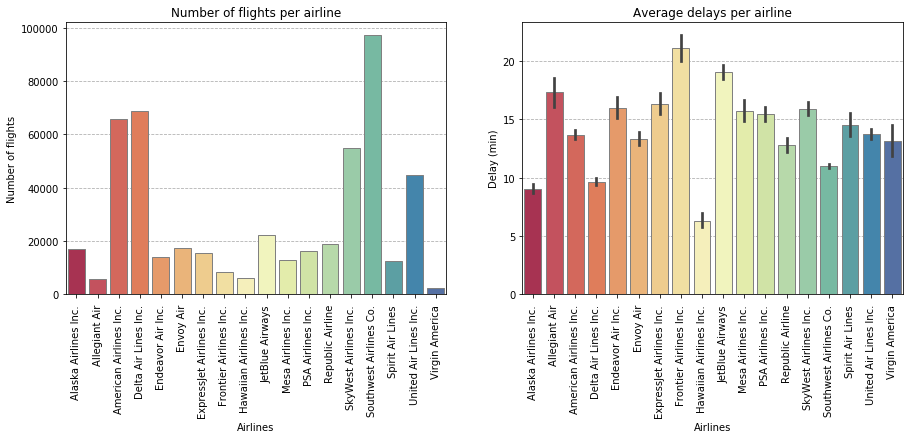

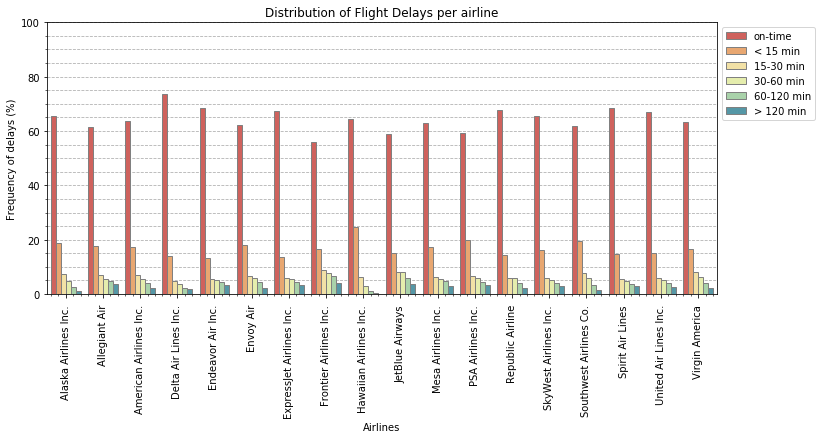

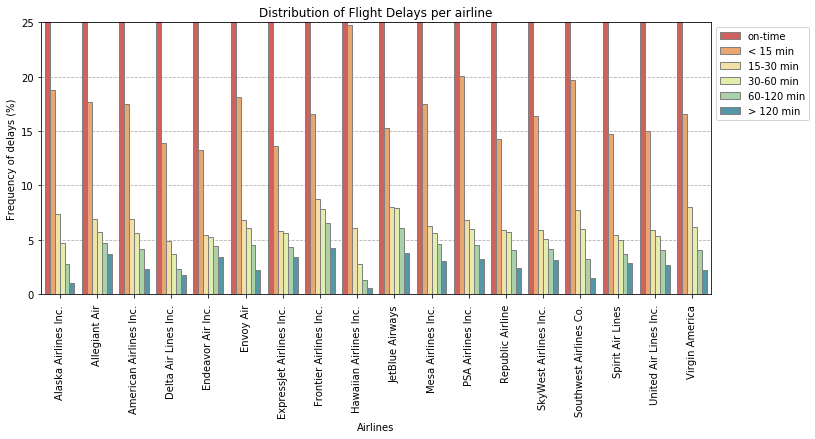

In [112]:
#----- total number of flights by airline -----
plt.figure(figsize=(15,5))
plt.subplot(121)
grid = sns.countplot(x='AIRLINE', data=train_explor, palette=sns.color_palette("Spectral",18), 
                     edgecolor = 'grey', zorder=2, order=np.sort(train_explor['AIRLINE'].unique()))
grid.set_title('Number of flights by airline')
grid.set_ylabel('Number of flights')
grid.set_xlabel('Airlines')
grid.yaxis.grid( which='both', linestyle='--')
plt.xticks(rotation=90)


#----- average delays at arrival by airline -----
plt.subplot(122)
grid = sns.barplot(x='AIRLINE', y='ARR_DELAY_NEW', data=train_explor, palette=sns.color_palette("Spectral", 18), 
                   edgecolor = 'grey', zorder=2, order=np.sort(train_explor['AIRLINE'].unique()))
grid.set_title('Average delays by airline')
grid.set_ylabel('Delay (min)')
grid.set_xlabel('Airlines')
grid.yaxis.grid(which='both', linestyle='--')
plt.xticks(rotation=90)
plt.show()


#----- Distribution of delays frequency by airline (binned) -----
plt.figure(figsize=(12,5))
grid = sns.barplot(x='AIRLINE', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_airline.reset_index(), 
                   palette=sns.color_palette("Spectral", 6), edgecolor = 'grey', zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of Flight Delays by airline')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Airlines')
grid.yaxis.grid(which='both', linestyle='--')
plt.xticks(rotation=90)
plt.ylim(0, 100)
grid.minorticks_on()
plt.show()


#----- Distribution of delays frequency by airline (zooming in, binned) -----
plt.figure(figsize=(12,5))
grid = sns.barplot(x='AIRLINE', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_airline.reset_index(), 
                   palette=sns.color_palette("Spectral", 6), edgecolor = 'grey', zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of Flight Delays by airline (zooming in)')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Airlines')
grid.yaxis.grid(which='both', linestyle='--')
plt.xticks(rotation=90)
plt.ylim(0, 25)
plt.show()

From the 18 airlines here depicted, Southwest Airlines, Delta Airlines, American Airlines and Skywest Airlines account together for more than 57% of all domestic flights in US. It does not seem to have a linear correlation between number of flights operated and delays, though. On average, delays at arrival over 10 min were observed for all airlines with exception of Hawaiian, Delta and Alaska Airlines, which did better. Frontier leads the list of less ponctual airline, with almost 45% of flights arriving late, followed by Jetblue with a bit more than 40%. Furthermore, both companies showed higher percentage of delays over 15 min and delays over 1h account for almost 10% of their flights. On the other hand, Delta flights arrived on scheduled on more than 75% of the time, and Hawaiian, with 65% of flights arriving in time, has an average delays of approximately 7 min and delays over 30 min accounting for less than 5% of its flights.

Apparently there is a correlation between low-costs airlines and delays. We can bin airlines into low-costs and full-servide airlines to check this hipothesis.

In [136]:
for df in [train_explor, flights_train, flights_test]:
    df['BIN_AIRLINE'] = df.OP_CARRIER.replace(['WN','B6','VX','F9','NK','G4'], 'Low_cost') \
                                     .replace(['OH','MQ','OO','EV','YX','YV','9E'], 'Regional') \
                                     .replace(['UA','HA','DL','AS','AA'], 'Full-service')

# updating feature control df
flights_FeatCtrl['BIN_AIRLINE'] = 3

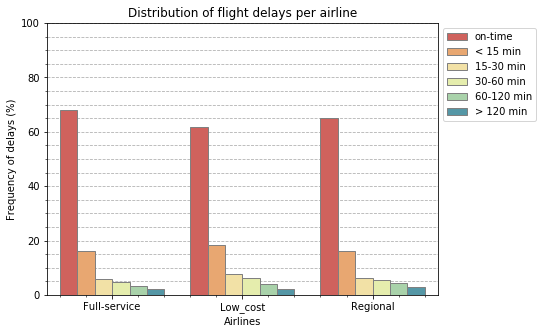

In [132]:
delays_count_airlinebin = train_explor[['BIN_AIRLINE', 'BIN_ARR_DELAY', 'ARR_DELAY_NEW']].groupby(['BIN_AIRLINE', 
                                                                                             'BIN_ARR_DELAY']).agg('count')
delay_per_airlinebin = delays_count_airlinebin.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

plt.figure(figsize=(7,5))
grid = sns.barplot(x='BIN_AIRLINE', y='ARR_DELAY_NEW', hue='BIN_ARR_DELAY', data=delay_per_airlinebin.reset_index(), 
                   palette=sns.color_palette("Spectral",6), edgecolor = 'grey', zorder=2)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
grid.set_title('Distribution of flight delays by airline')
grid.set_ylabel('Frequency of delays (%)')
grid.set_xlabel('Airlines')
grid.yaxis.grid( which='both', linestyle='--')
plt.ylim(0, 100)
grid.minorticks_on()
plt.show()

We can check later the effect of *BIN_AIRLINE* on model performance.

----
----
* ### Comparing delays by hour

In [ ]:
#time of the day
#airport category
#route
#distance
##xx.groupby(xx.SCHEDULED_ARR.dt.floor('30min'))['ARR_DELAY_NEW', 'DEP_DELAY_NEW'].mean()

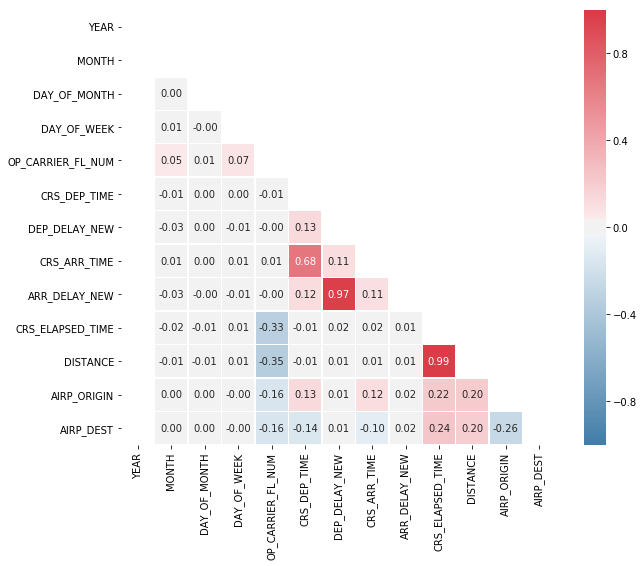

In [119]:
columns_to_keep = flights_FeatCtrl.loc[:, (flights_FeatCtrl != 2).any(axis=0)].columns

corr = flights_train[columns_to_keep].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
grid = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap=cmap, vmin=-1, center=0, linewidths=.5)
plt.show()

---------
---------
#### Outliers

From the histogram up above it seems that we have some outliers on delays time.

In [151]:
# flights on-time -- both on departure and arrival (delay dep = 0 and delay arr = 0)
ontime_arr_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW == 0) & (train_explor_10h.ARR_DELAY_NEW == 0)]

#flights that arrived on-time but departed late -- it did "make up time" in the air (delay dep > 0 and delay arr = 0)
ontime_arr_delay_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW > 0) & (train_explor_10h.ARR_DELAY_NEW == 0)]

#flights that arrived late but departed on-time -- it was longer than expected (delay dep = 0 and delay arr > 0)
delay_arr_ontime_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW == 0) & (train_explor_10h.ARR_DELAY_NEW > 0)]

#flights delayed -- both on departure and arrival (delay dep > 0 and delay arr > 0)
delay_arr_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW > 0) & (train_explor_10h.ARR_DELAY_NEW > 0)]

In [152]:
delay_arr_dep['DIFF_DEP_ARR_DELAY'] = delay_arr_dep.ARR_DELAY_NEW - delay_arr_dep.DEP_DELAY_NEW

#Flights that arrived later than expected (delay arr > delay dep)
delay_arr_greater_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY > 0]

#Flights that did "make up some time" in the air (delay arr < delay dep)
delay_arr_shorter_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY < 0]

#Flights that were as delayed at arrival as at departure (delay arr = delay dep)
delay_arr_equal_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY == 0]

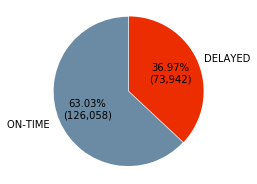

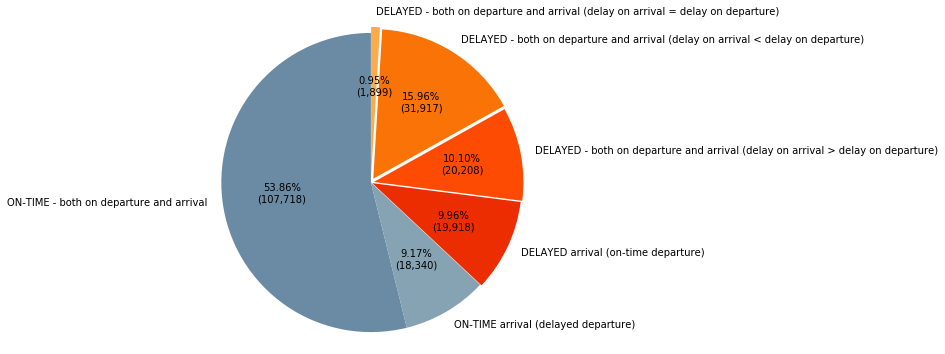

In [154]:
labels = ['ON-TIME ', 'DELAYED']
sizes = [len(ontime_arr_dep) + len(ontime_arr_delay_dep), len(delay_arr_ontime_dep) + len(delay_arr_dep)]
colors = ['#6b8ba4','#ec2d01'] 
explodeTuple = (0.0, 0.01)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p:'{:.2f}%\n({:,.0f})'.format(p,p*sum(sizes)/100), colors=colors, 
        explode=explodeTuple, startangle=90)
ax1.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(3,3)
plt.show()

labels = ['ON-TIME - both on departure and arrival', 'ON-TIME arrival (delayed departure)', 'DELAYED arrival (on-time departure)', 
          'DELAYED - both on departure and arrival (delay on arrival > delay on departure)',
          'DELAYED - both on departure and arrival (delay on arrival < delay on departure)', 
          'DELAYED - both on departure and arrival (delay on arrival = delay on departure)']
sizes = [len(ontime_arr_dep), len(ontime_arr_delay_dep), len(delay_arr_ontime_dep), len(delay_arr_greater_dep),
        len(delay_arr_shorter_dep), len(delay_arr_equal_dep)]
colors = ['#6b8ba4','#85a3b2','#ec2d01','#fe4b03', '#f97306','#fdaa48'] 
explodeTuple = (0.0, 0.0, 0.01,0.02,0.03,0.04)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p:'{:.2f}%\n({:,.0f})'.format(p,p*sum(sizes)/100), colors=colors, 
        explode=explodeTuple, startangle=90)
ax1.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()



-----------
-----------
Almost 63% of flights arrived on time, some of which (9.17%) manage to "make up time" and arrived on-time even with a delayed departure. From the 37% of flights that arrived late, almost 20% arrived later than expected due to a longer travel trip (longer than expected elapsed time) and 16% arrived late despite "making up some time" in the air (or in the ground with faster taxing, don't know).

One interesting thing to note is that the scatter plot up above is misleading: it seems that most of the delayed flights arrived even later than they departed. It is, actually, the opposite.

-------------
-------------

In [122]:
#size of airport bins
airports_capacity = pd.cut(airports_flights_per_month, [0, 250, 500, 1000, 5000, 10000, 20000, 80000]
                          ).value_counts().sort_index()
airports_capacity

(0, 250]          127
(250, 500]         41
(500, 1000]        55
(1000, 5000]       78
(5000, 10000]      16
(10000, 20000]     15
(20000, 80000]     19
dtype: int64